# IBM Coursera Capstone

### Clustering Neighborhoods in Canada

# Introduction
Canada is among the countries with a high immigration rates and in recent years it has become one of the most popular destination for educated professionals and skilled labor. In 2019 alone, Canada welcomed 341,000 immigrants and recently as per the new announcements it will be accepting over 400,000 immigrants per year between 2021-2023. This increase is to meet the economic growth targets and to replace the retiring workforce. Since Canada is a huge country standing at 9.985 Million Km2, relocation for immigrants thus poses a huge challenge. 
In this project, we will create a tool which will assist the immigrants in identifying different habitable and populated areas within Canada across all its provinces. In addition, we will segment the neighborhoods across different regions based on most common venues in the neighborhoods. This will enable the immigrants to quickly identify the regions and neighborhoods best suited for their purpose.

# Data Sources
To address the problem in question we will be using the location coordinates of major neighborhoods of Canada across all the provinces. This data can be downloaded for Canada from http://download.geonames.org/export/zip/. The data is in a tabular format so it can be read straight into pandas data frame. We will be using **Postal Code** (column 2), **Place Name** (column3), **Province Name** (column4), **Latitude** (column 10) and **Longitude** (column 11).
In addition, we will also be leveraging on Foursquare location data to pull in the most popular neighboring venues for each of the locations. We will achieve this through Foursquare APIs by passing the latitude and longitude location of each of the neighborhood into the ‘explore’ function below.

url= 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, LATITUDE ,LONGITUDE, RADIUS, LIMIT)

Where:
- CLIENT_ID and CLIENT_SECRET => Users credentials for Foursquare application
- LATITUDE, LONGITUDE  => Location coordinates of the neighborhood
- RADIUS => Distance in meters within which to search for venues
- LIMIT => Maximum number of venue results to return


# Import required libraries

Uncomment and run the following section if geocoder, geopy or folium libraries need to be installed

In [90]:
!pip3 install geocoder  #Uncomment if geocoder not installed
!pip3 install geopy # uncomment this line if geopy not installed
!pip3 install folium # uncomment this line if folium not installed

In [91]:
import pandas as pd
import numpy as np

import geocoder

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns # Seaborn visualization libray

import requests # library to handle requests

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Import Data

Extract the data file for Canada from http://download.geonames.org/export/zip/ and then store and retrive data from IBM cloud storage

In [92]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_875f503c00d047fb9e644b0a47a3875e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='gem7Zil0iX7YqjOkZycHENr0qVa5FIPRwY6zZBLjMwPd',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_875f503c00d047fb9e644b0a47a3875e.get_object(Bucket='ibmcapstone-donotdelete-pr-y8ldmihcxihjfd',Key='CA.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df1 = pd.read_csv(body)

print('The size of dataframe is =' ,df1.shape)
df1.head()

The size of dataframe is = (1656, 12)


Country Code Postal Code                       Neighbourhood Province  \
0           CA         T0A          Eastern Alberta (St. Paul)  Alberta   
1           CA         T0B         Wainwright Region (Tofield)  Alberta   
2           CA         T0C          Central Alberta (Stettler)  Alberta   
3           CA         T0E            Western Alberta (Jasper)  Alberta   
4           CA         T0G  North Central Alberta (Slave Lake)  Alberta   

  Province Code Borough  Borough Code Community  Community Code  Latitude  \
0            AB     NaN           NaN       NaN             NaN   54.7660   
1            AB     NaN           NaN       NaN             NaN   53.0727   
2            AB     NaN           NaN       NaN             NaN   52.1431   
3            AB     NaN           NaN       NaN             NaN   53.6758   
4            AB     NaN           NaN       NaN             NaN   55.6993   

   Longitude  Accuracy of Lat/Lon  
0  -111.7174                  6.0  
1  -111.5816                  6.0  
2  -111.6941                  5.0  
3  -115.0948                  5.0  
4  -114.4529                  6.0

# Data Wrangling and Cleaning
Perform the following steps

- Check data for missing values
- Identify and drop irrelevant columns
- Drop rows with missing values (if any)

## Check Missing Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country Code         1656 non-null   object 
 1   Postal Code          1656 non-null   object 
 2   Neighbourhood        1656 non-null   object 
 3   Province             1656 non-null   object 
 4   Province Code        1656 non-null   object 
 5   Borough              1038 non-null   object 
 6   Borough Code         303 non-null    float64
 7   Community            142 non-null    object 
 8   Community Code       142 non-null    float64
 9   Latitude             1656 non-null   float64
 10  Longitude            1656 non-null   float64
 11  Accuracy of Lat/Lon  1642 non-null   float64
dtypes: float64(5), object(7)
memory usage: 155.4+ KB


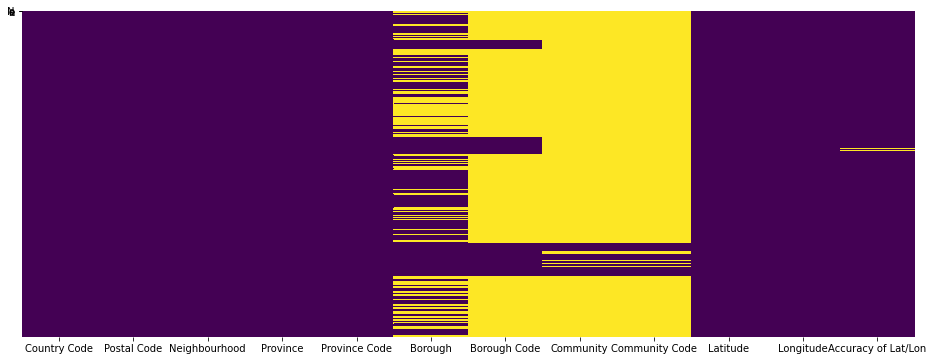

In [93]:
# Get stats on number of missing values and data type
df1.info()

# Make a heatmap of missing values to visualize missing values by columns
plt.figure(figsize=(16,6))
sns.heatmap(df1.isnull(), yticklabels='None', cmap='viridis', cbar=False)

It can be noticed that some columns such as **Borough**, **Bourough Code**, **Community** and **Community Code** have a significant rows with missing data, since none of these columns contains information we need for this project we will drop these columns all together.

In addition, **Country Code** is not required since entire dataset is for Canada, **Province Code** is also redundant since we already have a column of Province name and finally as we are performing a holistic analysis for entire Canada we also do not need **Accuracy of Lat/Lon** column to differentiate between precise and approximated locations.

In the next step we will drop these columns from dataset 

## Drop Irrelevant Columns

In [94]:
# Drop irrelevant colums
cols_to_drop = ['Country Code','Province Code','Borough','Borough Code','Community', 'Community Code', 'Accuracy of Lat/Lon']
df1.drop(cols_to_drop, axis = 1, inplace=True)

## Drop rows with any missing values

In [95]:
# Drop rows with NaNs
df1.dropna(inplace = True)

## Plot missing values again to confirm that the Dataset has been cleaned

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 1655
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Postal Code    1656 non-null   object 
 1   Neighbourhood  1656 non-null   object 
 2   Province       1656 non-null   object 
 3   Latitude       1656 non-null   float64
 4   Longitude      1656 non-null   float64
dtypes: float64(2), object(3)
memory usage: 77.6+ KB


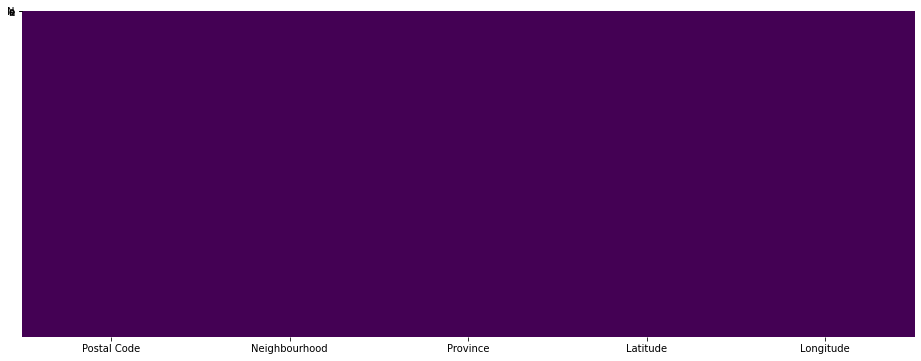

In [96]:
df1.info()# Get stats on number of missing values and data type

# Make a heatmap of missing values to visualize missing values by columns
plt.figure(figsize=(16,6))
sns.heatmap(df1.isnull(), yticklabels='None', cmap='viridis', cbar=False)

In [97]:
print('The size of cleaned dataframe is =' ,df1.shape)

The size of cleaned dataframe is = (1656, 5)


# EDA (Exploratory Data Analysis)

## Make a map of Canada with neighbourhoods superimposed on top

In [98]:
# Choose a location in Saskatchewan (Province in middle of Canada) to zoom on before adding markers to map
lat = df1[df1['Province']=='Saskatchewan'].iloc[0]['Latitude']
lon = df1[df1['Province']=='Saskatchewan'].iloc[0]['Longitude']

# Create map of Canada using latitude and longitude values
map_can = folium.Map(location=[lat, lon], zoom_start=4)

# Add markers to map
for lat, lng, province, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Province'], df1['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, province)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_can)  
    
map_can

The map above shows all the neighbourhoods scattered across Canada. We can easily see that most of these neighbourhoods are towards the South of Canada, as we move up towards the North they tend to get sparsely populated.

The scatter plot above may not be the best representation of the neighbourhoods density so lets create a heat map of all the neighbourhoods to easily visualize the information

## Make heat map of Canada to show densely populated regions

In [99]:
# Choose a location in Saskatchewan (Province in middle of Canada) to zoom on before adding markers to map
lat = df1[df1['Province']=='Saskatchewan'].iloc[0]['Latitude']
lon = df1[df1['Province']=='Saskatchewan'].iloc[0]['Longitude']

# Create map of Canada using latitude and longitude values
map_can = folium.Map(location=[lat, lon], zoom_start=4)

# Add markers to map
for lat, lng, province, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Province'], df1['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, province)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='k',
        fill=True,
        fill_color='k',
        fill_opacity=0.1,
        parse_html=False).add_to(map_can)  

hm = plugins.HeatMap(df1[['Latitude','Longitude']], radius=15)
map_can.add_child(hm)
map_can

From this heat map it gets very clear now that most of the popular neighbourhoods are populated closer to the US border. From the density of black point on the map you could easily identify the major cities form West to East such as Vancouver, Calgary, Edmonton, Toronto, Ottawa, Montreal, Halifax. Combining the data science methodologies along with visualizations we are now able to understand neighbourhoods across Canada. This kind of information is very useful for a new immigrant who needs to make a choice of which region to move to

#### Next we will find the most popular venues in each neighbourhood and cluster the neighbourhoods together to identify which neighbourhoods across different cities in Canada are similar

### Define Foursquare Credentials and Version

In [100]:
CLIENT_ID = 'HSVBGX3IVTH45XW3KZM3DRSBRL1ASRSV0XE2OIX5WWZJGODN' # your Foursquare ID
CLIENT_SECRET = 'QKNIVK55YUS1LYMR3JZPMKUBYET1Q3UYFKIWKRZSLEQHH2GT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Create a function to extract the category of the venue

In [101]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Let's create a function to repeat the same process to all the neighborhoods in Canada

In [102]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Run the function on each neighbourhood to find all venues

In [103]:
canada_venues = getNearbyVenues(names=df1['Neighbourhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )
print(canada_venues.shape)
canada_venues.head()

Eastern Alberta (St. Paul)
Wainwright Region (Tofield)
Central Alberta (Stettler)
Western Alberta (Jasper)
North Central Alberta (Slave Lake)
Northwestern Alberta (High Level)
Southeastern Alberta (Drumheller)
International Border Region (Cardston)
Kananaskis Country (Claresholm)
Central Foothills (Sundre)
Northeastern Alberta (Fort Chipewyan)
Remote Northeast (Fitzgerald)
Medicine Hat Central
Medicine Hat South
Medicine Hat North
Taber
Lethbridge North
Lethbridge West and Central
Lethbridge Southeast
Banff
Coaldale
Strathmore
Brooks
Okotoks
High River
Canmore
Chestermere
Calgary (Rundle / Whitehorn / Monterey Park)
Rocky View
Calgary (Penbrooke Meadows / Marlborough)
Calgary (Forest Lawn / Dover / Erin Woods)
Calgary (Lynnwood Ridge / Ogden / Foothills Industrial / Great Plains)
Calgary (Bridgeland / Greenview / Zoo / YYC)
Calgary (Inglewood / Burnsland / Chinatown / East Victoria Park / Saddledome)
Calgary (Highfield / Burns Industrial)
Calgary (Queensland Downs / Lake Bonavista / Wi

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Taber                 49.787                -112.146   
1        Taber                 49.787                -112.146   
2        Taber                 49.787                -112.146   
3        Taber                 49.787                -112.146   
4        Taber                 49.787                -112.146   

                      Venue  Venue Latitude  Venue Longitude  \
0               Dairy Queen       49.786138      -112.144488   
1                    Subway       49.784526      -112.144516   
2                       A&W       49.783231      -112.148470   
3                 Pizza Hut       49.785695      -112.144023   
4  Dennis' Mobile Glass Ltd       49.785549      -112.139963   

         Venue Category  
0        Ice Cream Shop  
1        Sandwich Place  
2  Fast Food Restaurant  
3           Pizza Place  
4          Home Service

### Check how many venues were retured for each neighbourhood

In [104]:
# Drop rows where the venue category comes out to be simply as 'Neighbourhood'
canada_venues = canada_venues[canada_venues['Venue Category'] != 'Neighborhood']

Before proceeding to clustering the data, lets first remove all neighbourhoods where there are less than 5 venues in vicinity. We are doing this to remove isolated neighbourhoods and this way the clusters we create will be more meaningful for someone to examine and make relocation decisions

In [105]:
# Drop Neighbourhoods where less than 5 Neighbourhoods returned
mask = canada_venues.groupby('Neighborhood').count()[['Neighborhood Latitude']]
neighbourhoods_to_drop = mask[mask['Neighborhood Latitude'] <=5].index

canada_venues1 = canada_venues[~canada_venues['Neighborhood'].isin(neighbourhoods_to_drop)]

In [106]:
canada_venues1.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                   
Acton                                                      6   
Ahuntsic Central                                          18   
Ahuntsic Southeast                                        22   
Ahuntsic Southwest                                        14   
Ajax Southwest                                            21   
...                                                      ...   
Woodbridge North                                           7   
Woodstock South                                            8   
York (Cedarvale)                                           7   
York (Fairbank / Oakwood)                                  8   
York (Runnymede / The Junction North)                      7   

                                       Neighborhood Longitude  Venue  \
Neighborhood                                                           
Acton                                                       6      6   
Ahuntsic Central                                           18     18   
Ahuntsic Southeast                                         22     22   
Ahuntsic Southwest                                         14     14   
Ajax Southwest                                             21     21   
...                                                       ...    ...   
Woodbridge North                                            7      7   
Woodstock South                                             8      8   
York (Cedarvale)                                            7      7   
York (Fairbank / Oakwood)                                   8      8   
York (Runnymede / The Junction North)                       7      7   

                                       Venue Latitude  Venue Longitude  \
Neighborhood                                                             
Acton                                               6                6   
Ahuntsic Central                                   18               18   
Ahuntsic Southeast                                 22               22   
Ahuntsic Southwest                                 14               14   
Ajax Southwest                                     21               21   
...                                               ...              ...   
Woodbridge North                                    7                7   
Woodstock South                                     8                8   
York (Cedarvale)                                    7                7   
York (Fairbank / Oakwood)                           8                8   
York (Runnymede / The Junction North)               7                7   

                                       Venue Category  
Neighborhood                                           
Acton                                               6  
Ahuntsic Central                                   18  
Ahuntsic Southeast                                 22  
Ahuntsic Southwest                                 14  
Ajax Southwest                                     21  
...                                               ...  
Woodbridge North                                    7  
Woodstock South                                     8  
York (Cedarvale)                                    7  
York (Fairbank / Oakwood)                           8  
York (Runnymede / The Junction North)               7  

[389 rows x 6 columns]

### Find number of unique categories of venues

In [107]:
print('There are {} uniques categories.'.format(len(canada_venues1['Venue Category'].unique())))

There are 402 uniques categories.


# Analyze Each Neigborhood

One hot encode to encode categorical features

In [108]:
# one hot encoding
onehot = pd.get_dummies(canada_venues1[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = canada_venues1['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
9         Banff                  0               0                  0   
10        Banff                  0               0                  0   
11        Banff                  0               0                  0   
12        Banff                  0               0                  0   
13        Banff                  0               0                  0   

    African Restaurant  Airport  Airport Lounge  Airport Service  \
9                    0        0               0                0   
10                   0        0               0                0   
11                   0        0               0                0   
12                   0        0               0                0   
13                   0        0               0                0   

    Airport Terminal  American Restaurant  ...  Vietnamese Restaurant  \
9                  0                    0  ...                      0   
10                 0                    0  ...                      0   
11                 0                    0  ...                      0   
12                 0                    0  ...                      0   
13                 0                    0  ...                      0   

    Warehouse Store  Waterfront  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
9                 0           0           0         0          0            0   
10                0           0           0         0          0            0   
11                0           0           0         0          0            0   
12                0           0           0         0          0            0   
13                0           0           0         0          0            0   

    Women's Store  Xinjiang Restaurant  Yoga Studio  
9               0                    0            0  
10              0                    0            0  
11              0                    0            0  
12              0                    0            0  
13              0                    0            0  

[5 rows x 403 columns]

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [109]:
canada_grouped = onehot.groupby('Neighborhood').mean().reset_index()
canada_grouped.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0               Acton                0.0             0.0                0.0   
1    Ahuntsic Central                0.0             0.0                0.0   
2  Ahuntsic Southeast                0.0             0.0                0.0   
3  Ahuntsic Southwest                0.0             0.0                0.0   
4      Ajax Southwest                0.0             0.0                0.0   

   African Restaurant  Airport  Airport Lounge  Airport Service  \
0                 0.0      0.0             0.0              0.0   
1                 0.0      0.0             0.0              0.0   
2                 0.0      0.0             0.0              0.0   
3                 0.0      0.0             0.0              0.0   
4                 0.0      0.0             0.0              0.0   

   Airport Terminal  American Restaurant  ...  Vietnamese Restaurant  \
0               0.0                  0.0  ...               0.000000   
1               0.0                  0.0  ...               0.055556   
2               0.0                  0.0  ...               0.000000   
3               0.0                  0.0  ...               0.000000   
4               0.0                  0.0  ...               0.000000   

   Warehouse Store  Waterfront  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0              0.0         0.0         0.0  0.000000        0.0     0.000000   
1              0.0         0.0         0.0  0.000000        0.0     0.000000   
2              0.0         0.0         0.0  0.000000        0.0     0.000000   
3              0.0         0.0         0.0  0.071429        0.0     0.000000   
4              0.0         0.0         0.0  0.000000        0.0     0.047619   

   Women's Store  Xinjiang Restaurant  Yoga Studio  
0            0.0                  0.0          0.0  
1            0.0                  0.0          0.0  
2            0.0                  0.0          0.0  
3            0.0                  0.0          0.0  
4            0.0                  0.0          0.0  

[5 rows x 403 columns]

### Function to sort the venues in descending order

In [110]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create the new dataframe and display the top 5 venues for each neighborhood.

Since in the earlier step we already removed neighbourhoods with less than 5 venues, we can now cluster neighbourhoods based on 5 popular venues in vicinity.

In [111]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = canada_grouped['Neighborhood']

for ind in np.arange(canada_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(canada_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue   2nd Most Common Venue  \
0               Acton     Convenience Store            Soccer Field   
1    Ahuntsic Central                  Café          Ice Cream Shop   
2  Ahuntsic Southeast        Clothing Store  Furniture / Home Store   
3  Ahuntsic Southwest              Pharmacy          Ice Cream Shop   
4      Ajax Southwest  Fast Food Restaurant             Pizza Place   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0        Sandwich Place       Thai Restaurant         Deli / Bodega  
1                 Diner           Coffee Shop         Grocery Store  
2                Bakery        Sandwich Place    Italian Restaurant  
3            Restaurant        Farmers Market                  Café  
4        Breakfast Spot        Ice Cream Shop  Gym / Fitness Center

# Cluster Neighborhoods

### Define a function to run K-Means and then use Elbow method to identify the optimum number of cluster for this dataset

In [112]:
# Instantiate fit, predict and score function
def kmean_score(data,number_of_clusters):
    kmeans = KMeans(number_of_clusters)
    km_model = kmeans.fit(data)
    km_labels = km_model.predict(data)
    km_model_score=abs(km_model.score(data))
    
    return km_model_score

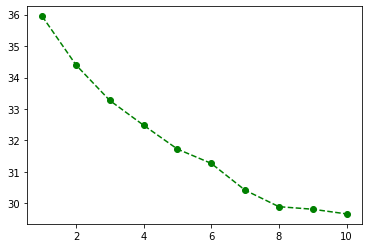

In [113]:
# Loop to get all scores
canada_grouped_clustering = canada_grouped.drop('Neighborhood', 1)
num_clusters=list(range(1,11))
score_appended=[]
for i in num_clusters:
    score_appended.append(kmean_score(canada_grouped_clustering,i))
    
# Plot and choose optimum number of clusters
plt.plot(num_clusters,score_appended, linestyle='--', marker='o', color='green')


### Run _k_-means to cluster the neighborhood into 6 clusters.

In [114]:
# set number of clusters
kclusters = 6

canada_grouped_clustering = canada_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(canada_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 5, 5, 4, 2, 4, 3, 2, 2, 4], dtype=int32)

### Create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [115]:
neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue  \
0                                    Acton     Convenience Store   
1                         Ahuntsic Central                  Café   
2                       Ahuntsic Southeast        Clothing Store   
3                       Ahuntsic Southwest              Pharmacy   
4                           Ajax Southwest  Fast Food Restaurant   
..                                     ...                   ...   
384                       Woodbridge North        Ice Cream Shop   
385                        Woodstock South                 Hotel   
386                       York (Cedarvale)                  Park   
387              York (Fairbank / Oakwood)                  Park   
388  York (Runnymede / The Junction North)               Brewery   

      2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0              Soccer Field        Sandwich Place       Thai Restaurant   
1            Ice Cream Shop                 Diner           Coffee Shop   
2    Furniture / Home Store                Bakery        Sandwich Place   
3            Ice Cream Shop            Restaurant        Farmers Market   
4               Pizza Place        Breakfast Spot        Ice Cream Shop   
..                      ...                   ...                   ...   
384      Mexican Restaurant                  Bank             Pet Store   
385    Fast Food Restaurant            Steakhouse           Yoga Studio   
386                   Field         Grocery Store          Hockey Arena   
387              Beer Store    Mexican Restaurant                   Gym   
388  Furniture / Home Store                  Park    Athletics & Sports   

    5th Most Common Venue  
0           Deli / Bodega  
1           Grocery Store  
2      Italian Restaurant  
3                    Café  
4    Gym / Fitness Center  
..                    ...  
384              Pharmacy  
385         Event Service  
386            Playground  
387                Bakery  
388           Event Space  

[389 rows x 6 columns]

In [116]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

canada_merged = df1

# merge canada_merged with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
canada_merged = canada_merged.merge(neighborhoods_venues_sorted, how= 'left', left_on='Neighbourhood', right_on='Neighborhood')

# Drop NaNs
canada_merged.dropna(axis=0, how='any', inplace=True)
canada_merged['Cluster Labels'] = canada_merged['Cluster Labels'].astype('int')

canada_merged.head() # check the last columns!

Postal Code                                 Neighbourhood Province  \
19         T1L                                         Banff  Alberta   
25         T1W                                       Canmore  Alberta   
27         T1Y  Calgary (Rundle / Whitehorn / Monterey Park)  Alberta   
34         T2H        Calgary (Highfield / Burns Industrial)  Alberta   
36         T2K               Calgary (Thornecliffe / Tuxedo)  Alberta   

    Latitude  Longitude  Cluster Labels  \
19   51.1762  -115.5698               5   
25   51.0876  -115.3461               1   
27   51.0823  -113.9578               4   
34   50.9894  -114.0520               2   
36   51.1111  -114.0477               5   

                                    Neighborhood  1st Most Common Venue  \
19                                         Banff                  Hotel   
25                                       Canmore                  Hotel   
27  Calgary (Rundle / Whitehorn / Monterey Park)          Grocery Store   
34        Calgary (Highfield / Burns Industrial)        Warehouse Store   
36               Calgary (Thornecliffe / Tuxedo)  General Entertainment   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
19              Steakhouse                   Pub   Sporting Goods Shop   
25                 Dog Run                   Pub                Resort   
27          Discount Store    Chinese Restaurant           Gas Station   
34  Furniture / Home Store              Gun Shop  Fast Food Restaurant   
36      Chinese Restaurant        Sandwich Place    Athletics & Sports   

   5th Most Common Venue  
19        Clothing Store  
25               Brewery  
27        Sandwich Place  
34        Farmers Market  
36            Restaurant

In [117]:
# Choose a location in Saskatchewan (Province in middle of Canada) to zoom on before adding markers to map
lat = df1[df1['Province']=='Saskatchewan'].iloc[0]['Latitude']
lon = df1[df1['Province']=='Saskatchewan'].iloc[0]['Longitude']

# create map
map_clusters = folium.Map(location=[lat, lon], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(canada_merged['Latitude'], canada_merged['Longitude'], canada_merged['Neighborhood'], canada_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



## Key Observations 

The map above shows the most popular neighbourhoods in Canada colored by the cluster they belong to. It can be noticed that they most popular neighbourhoods are in the major cities. Now lets explore and describe each of these clusters

### Examine and display Clusters
To verbally Categorize the clusters we will look at the 1st Most Common Venue and identify the most popular choices

### Cluster 1 -> For Coffee Lovers

Text(0.5, 1.0, 'Cluster1 - Coffee Lovers')

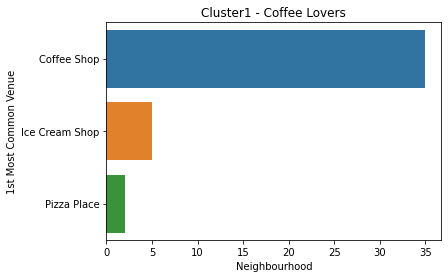

In [118]:
c1 = canada_merged.loc[canada_merged['Cluster Labels'] == 0, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]
c1t = c1.groupby(['1st Most Common Venue']).count()[['Neighbourhood']].sort_values(by='Neighbourhood',ascending=False).head(3).reset_index()
sns.barplot( c1t['Neighbourhood'],c1t['1st Most Common Venue'], orient='h')
plt.title('Cluster1 - Coffee Lovers')

### Cluster 2 -> For Businesses

Text(0.5, 1.0, 'Cluster2 - For Businesses and Events')

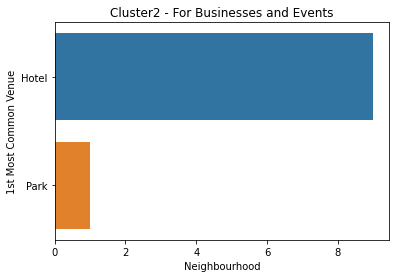

In [119]:
c2 = canada_merged.loc[canada_merged['Cluster Labels'] == 1, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]
c2t = c2.groupby(['1st Most Common Venue']).count()[['Neighbourhood']].sort_values(by='Neighbourhood',ascending=False).head(3).reset_index()
sns.barplot( c2t['Neighbourhood'],c2t['1st Most Common Venue'], orient='h')
plt.title('Cluster2 - For Businesses and Events')

### Cluster 3 -> For Fastfood Fans

Text(0.5, 1.0, 'Cluster3 - For Fastfood Fans')

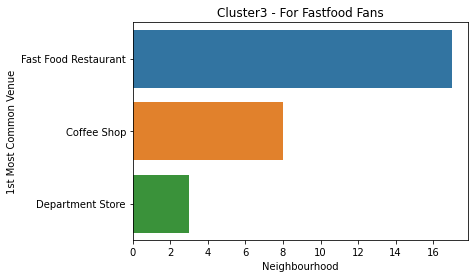

In [120]:
c3 = canada_merged.loc[canada_merged['Cluster Labels'] == 2, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]
c3t = c3.groupby(['1st Most Common Venue']).count()[['Neighbourhood']].sort_values(by='Neighbourhood',ascending=False).head(3).reset_index()
sns.barplot( c3t['Neighbourhood'],c3t['1st Most Common Venue'], orient='h')
plt.title('Cluster3 - For Fastfood Fans')

### Cluster 4 -> For Outdoor Enthusiasts

Text(0.5, 1.0, 'Cluster4 - For Outdoor Enthusiasts')

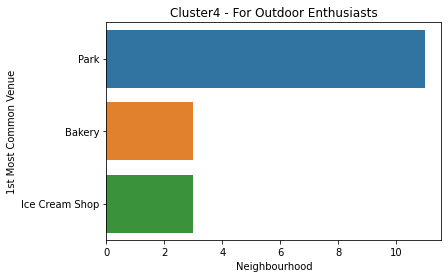

In [121]:
c4 = canada_merged.loc[canada_merged['Cluster Labels'] == 3, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]
c4t = c4.groupby(['1st Most Common Venue']).count()[['Neighbourhood']].sort_values(by='Neighbourhood',ascending=False).head(3).reset_index()
sns.barplot( c4t['Neighbourhood'],c4t['1st Most Common Venue'], orient='h')
plt.title('Cluster4 - For Outdoor Enthusiasts')

### Cluster 5 -> For Those Seeking Daily Convenience

Text(0.5, 1.0, 'Cluster5 - For Convenience Seekers')

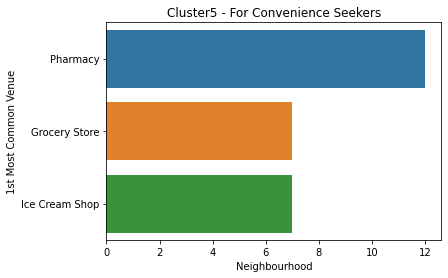

In [122]:
c5 = canada_merged.loc[canada_merged['Cluster Labels'] == 4, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]
c5t = c5.groupby(['1st Most Common Venue']).count()[['Neighbourhood']].sort_values(by='Neighbourhood',ascending=False).head(3).reset_index()
sns.barplot( c5t['Neighbourhood'],c5t['1st Most Common Venue'], orient='h')
plt.title('Cluster5 - For Convenience Seekers')


### Cluster 6 -> For Those Who Enjoy Dining Out

Text(0.5, 1.0, 'Cluster6 - For Dineout Fans')

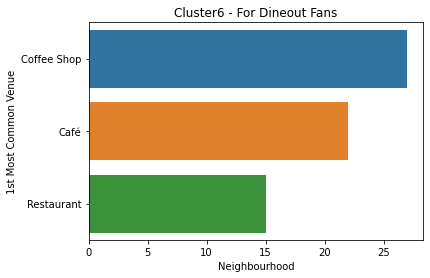

In [123]:
c6 = canada_merged.loc[canada_merged['Cluster Labels'] == 5, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]
c6t = c6.groupby(['1st Most Common Venue']).count()[['Neighbourhood']].sort_values(by='Neighbourhood',ascending=False).head(3).reset_index()
sns.barplot( c6t['Neighbourhood'],c6t['1st Most Common Venue'], orient='h')
plt.title('Cluster6 - For Dineout Fans')

## Summary

Based on these results:
- Cluster 1 : Neigbourhood popular with people who love coffee
- Cluster 2 : Neighbourhood with a lot of Hotels around
- Cluster 3 : Neighbourhood popular with people who prefer Fastfood
- Cluster 4 : Neighbourhood popular with people who enjoy outdoors
- Cluster 5 : Neighbourhood with Pharmacies and Grocery store around for those who prefer convenience
- Cluster 6 : Cluster 6 is somehow similar to Cluster 1, but also features Cafes and Restaurants